In [1]:
import toml
import joblib
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from rl_analysis import ANALYSIS_CONFIG
from rl_analysis.io.df import dlight_exclude_toml, load_dlight_features
from rl_analysis.plotting import save_factory, setup_plotting_env, clean_ticks, fg, add_legend

warnings.simplefilter('ignore')

In [2]:
with open(ANALYSIS_CONFIG, 'r') as f:
    config = toml.load(f)

In [3]:
setup_plotting_env()

saver = save_factory(join(config['figures']['dir_wg'], 'variability-fig'), tight_layout=False)

plt.rcParams['figure.dpi'] = 300

In [4]:
use_dct = dlight_exclude_toml(
    "/home/wg41/reinforcement_data/_proc_photometry_dlight/dlight_photometry_processed_full.toml",
    **config["dlight_common"]
)

feat_df = load_dlight_features(config['intermediate_results']['features_public'])
feat_df = feat_df[feat_df['uuid'].isin(use_dct)]

In [5]:
sorting = joblib.load('/home/wg41/reinforcement_data/dlight_photometry/fig1-syllable-sorting.p')

## Plot distribution of DA peak instances per syllable

In [6]:
quant_range = 0.99
edges = np.histogram_bin_edges(
    feat_df["signal_reref_dff_z_max"].dropna(),
    bins=75,
    range=(-0.95, feat_df["signal_reref_dff_z_max"].quantile(quant_range)),
)
x = edges[:-1] + (np.diff(edges) / 2)

dists = []
avgs = []
for syll in sorting:
    tmp = feat_df.loc[feat_df["syllable"] == syll, "signal_reref_dff_z_max"]
    dist, _bins = np.histogram(tmp, edges, density=True)
    dists.append(dist)
    avgs.append(tmp.mean())

dists = np.array(dists)

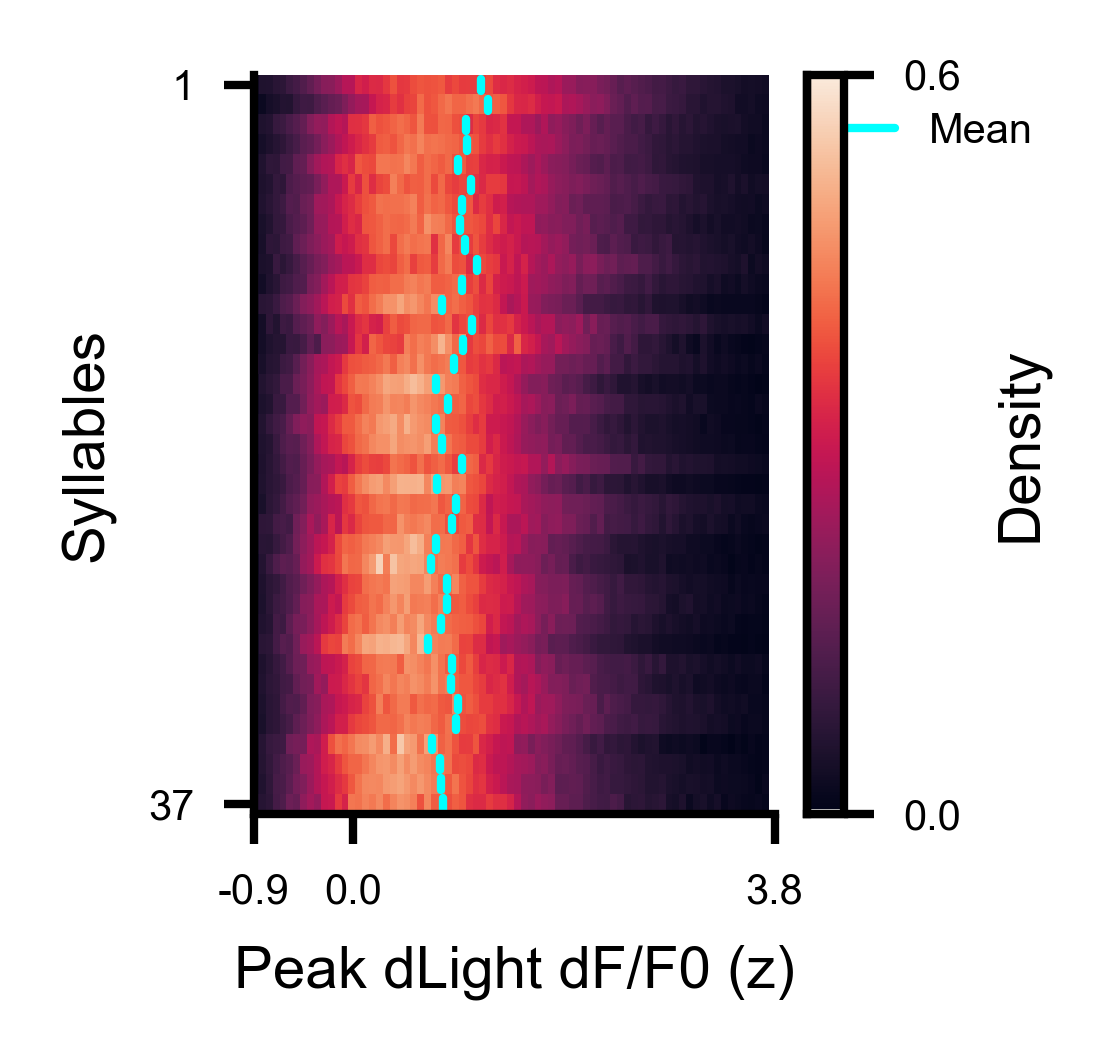

In [7]:
pad = 0.2
fig = fg(1.4, 1.6)
fig.dpi = 300
ax = fig.gca()
im = ax.imshow(
    dists, aspect="auto", extent=(x[0], x[-1], len(sorting), 0), vmax=0.6, interpolation="none"
)
cb = fig.colorbar(im, ax=ax, label="Density")
cb.set_ticks([0, 0.6])
for i in range(len(avgs)):
    plt.plot((avgs[i],) * 2, (i + pad, i + (1 - pad)), lw=1, c="cyan", label='Mean' if i == 0 else None)
ax.set(
    xlabel="Peak dLight dF/F0 (z)",
    ylabel="Syllables",
    yticks=[0.5, len(sorting) - 0.5],
    yticklabels=[1, len(sorting)],
    ylim=(len(sorting), 0),
    xlim=(-0.9, None),
)
clean_ticks(ax, axis="x", zero_symmetry=False, precision=1)
sns.despine()
add_legend(ax)
saver(fig, "prob-density-of-dlight-instances");

## Plot distribution of avg DA peaks per session and per syllable

In [8]:
avg_peak_dlight = feat_df.groupby(['uuid', 'syllable'])['signal_reref_dff_z_max'].mean().reset_index()

In [9]:
quant_range = 0.99
edges = np.histogram_bin_edges(
    avg_peak_dlight["signal_reref_dff_z_max"].dropna(),
    bins=38,
    range=(-0.05, avg_peak_dlight["signal_reref_dff_z_max"].quantile(quant_range)),
)
x = edges[:-1] + (np.diff(edges) / 2)

avg_dists = []
avg_means = []
for syll in sorting:
    tmp = avg_peak_dlight.loc[avg_peak_dlight["syllable"] == syll, "signal_reref_dff_z_max"]
    dist, _bins = np.histogram(tmp, edges, density=True)
    avg_dists.append(dist)
    avg_means.append(tmp.mean())

avg_dists = np.array(avg_dists)

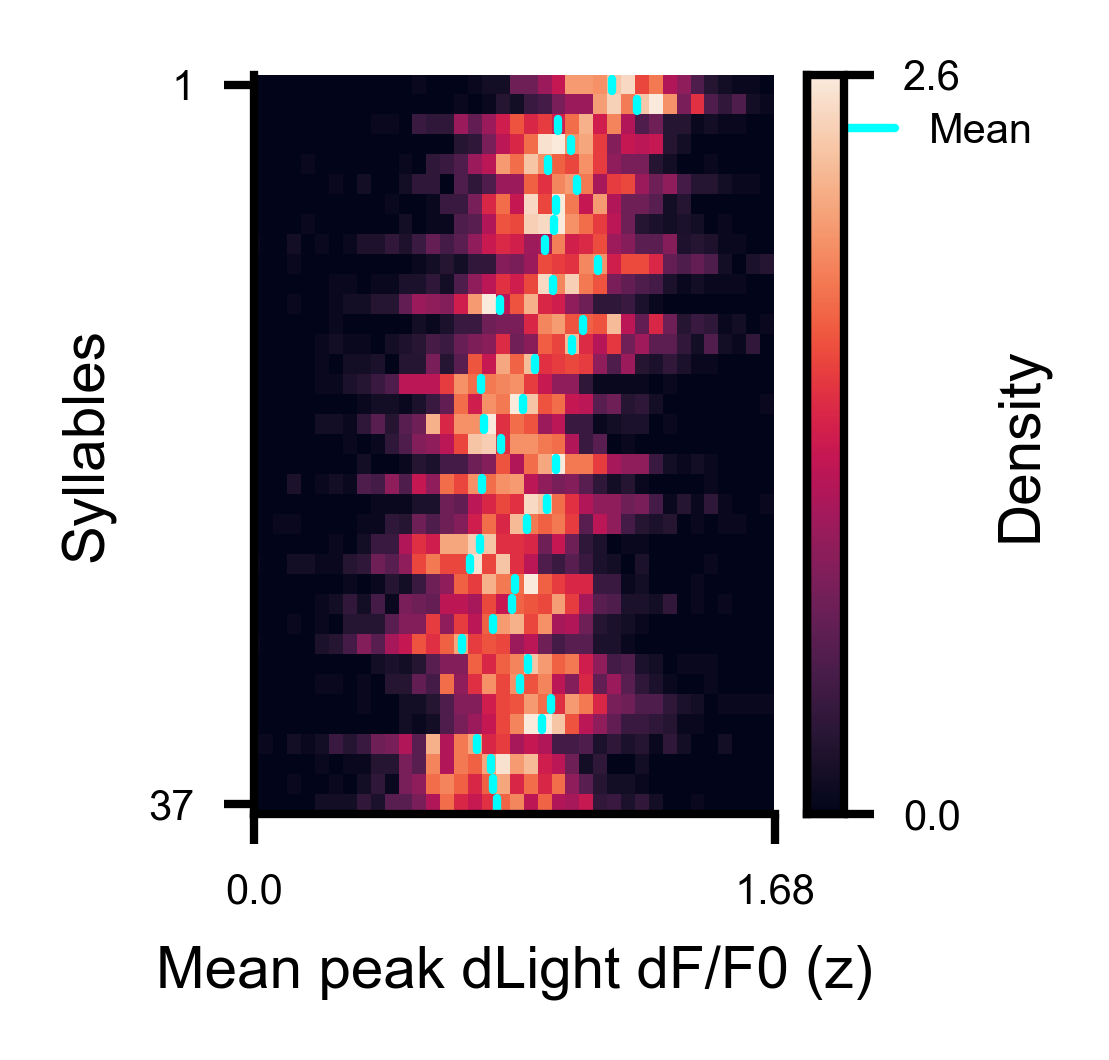

In [10]:
pad = 0.2
fig = fg(1.4, 1.6)
fig.dpi = 300
ax = fig.gca()
im = ax.imshow(
    avg_dists,
    aspect="auto",
    extent=(x[0], x[-1], len(sorting), 0),
    vmax=2.6,
    interpolation="none",
)
cb = fig.colorbar(im, ax=ax, label="Density")
for i in range(len(avg_dists)):
    plt.plot((avg_means[i],) * 2, (i + pad, i + (1 - pad)), lw=1, c="cyan", label='Mean' if i == 0 else None)
cb.set_ticks([0, 2.6])
ax.set(
    xlabel="Mean peak dLight dF/F0 (z)",
    ylabel="Syllables",
    yticks=[0.5, len(sorting) - 0.5],
    yticklabels=[1, len(sorting)],
    ylim=(len(sorting), 0),
    xlim=(0, None),
)
clean_ticks(ax, axis="x", dtype=float, zero_symmetry=False, precision=2)
sns.despine()
add_legend(ax)
saver(fig, "prob-density-of-avg-dlight-across-sessions");